# YOLOv11 on Blood Cell Dataset

## Introduction

This notebook focuses on training and evaluating the YOLOv11 model for blood cell detection and classification. The dataset consists of images of different blood cell types, each labeled with corresponding bounding boxes. The key objectives of this notebook are:

- **Data Preparation:** Cleaning the dataset by removing incorrectly labeled images and augmenting data if necessary.
- **Model Training:** Fine-tuning the YOLOv11 model using a pretrained weight (`yolo11n.pt`).

For more details on YOLOv11, refer to the official [Ultralytics documentation](https://docs.ultralytics.com).

In [ ]:
%pip install ultralytics

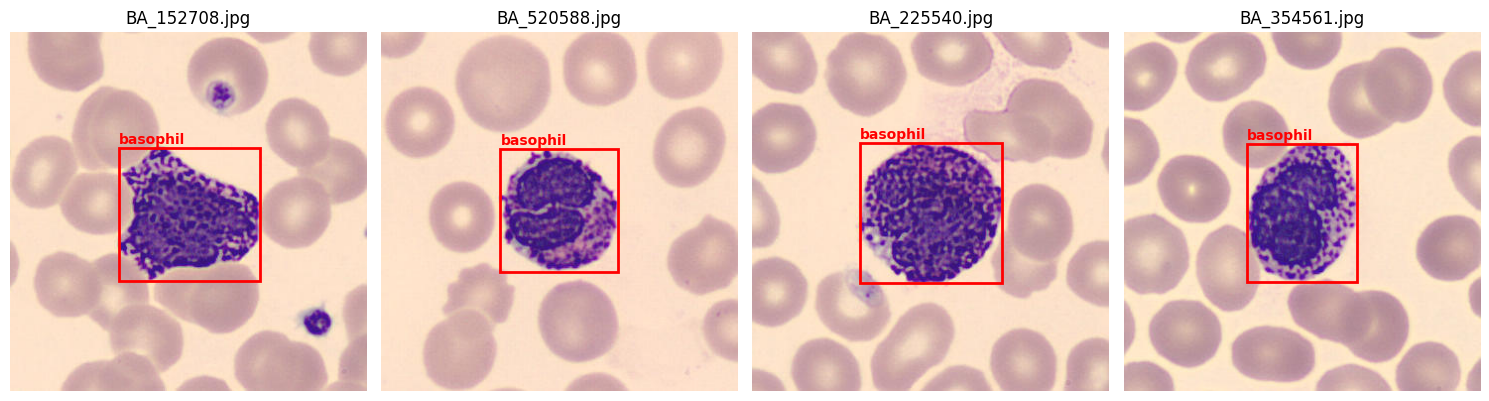

In [85]:
%matplotlib inline
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define paths
image_dir = "/Users/afnanag/projects/DH307/yolov11/data/basophil/images"
label_dir = "/Users/afnanag/projects/DH307/yolov11/data/basophil/labels"

# Class names (index corresponds to YOLO label)
class_names = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin', 
               'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Get all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Select random images
num_images_to_display = 4
selected_images = random.sample(image_files, min(num_images_to_display, len(image_files)))

# Function to read labels and parse YOLO format
def load_yolo_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            labels.append((class_id, x_center, y_center, width, height))
    return labels

# Plot images with bounding boxes
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

    # Read image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    # Get image dimensions
    h, w, _ = image.shape

    # Read labels
    labels = load_yolo_labels(label_path)

    # Plot image
    ax = axes[i] if len(selected_images) > 1 else axes
    ax.imshow(image)
    ax.set_title(img_name)
    ax.axis("off")

    # Draw bounding boxes
    for class_id, x_center, y_center, width, height in labels:
        # Convert YOLO format to pixel values
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        box_w = int(width * w)
        box_h = int(height * h)

        # Create rectangle
        rect = patches.Rectangle((x_min, y_min), box_w, box_h, linewidth=2, 
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, class_names[class_id], color='red', fontsize=10, weight='bold')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Remove Images Without Labels

In [86]:
# Define paths
platelets_img_dir = "/Users/afnanag/projects/DH307/yolov11/data/platelet/images"
platelets_lbl_dir = "/Users/afnanag/projects/DH307/yolov11/data/platelet/labels"

# Get all image names (without extension)
image_files = [f for f in os.listdir(platelets_img_dir) if f.endswith('.jpg')]

# Delete images that don't have a matching label
for img_file in image_files:
    label_file = img_file.replace('.jpg', '.txt')
    label_path = os.path.join(platelets_lbl_dir, label_file)

    if not os.path.exists(label_path):
        os.remove(os.path.join(platelets_img_dir, img_file))
        print(f"Deleted: {img_file}")

print("Cleanup complete: Removed images without labels.")


Deleted: PLATELET_70358.jpg
Deleted: PLATELET_127607.jpg
Deleted: PLATELET_8089.jpg
Deleted: PLATELET_208927.jpg
Deleted: PLATELET_451360.jpg
Deleted: PLATELET_296115.jpg
Deleted: PLATELET_559926.jpg
Deleted: PLATELET_568251.jpg
Deleted: PLATELET_342998.jpg
Deleted: PLATELET_287352.jpg
Deleted: PLATELET_111377.jpg
Deleted: PLATELET_459305.jpg
Deleted: PLATELET_194627.jpg
Deleted: PLATELET_450479.jpg
Deleted: PLATELET_71521.jpg
Deleted: PLATELET_562150.jpg
Deleted: PLATELET_634351.jpg
Deleted: PLATELET_415455.jpg
Deleted: PLATELET_481546.jpg
Deleted: PLATELET_68662.jpg
Deleted: PLATELET_430945.jpg
Deleted: PLATELET_175036.jpg
Deleted: PLATELET_830843.jpg
Deleted: PLATELET_930880.jpg
Deleted: PLATELET_390200.jpg
Deleted: PLATELET_147287.jpg
Deleted: PLATELET_145453.jpg
Deleted: PLATELET_327246.jpg
Deleted: PLATELET_358860.jpg
Deleted: PLATELET_620286.jpg
Deleted: PLATELET_138731.jpg
Deleted: PLATELET_534883.jpg
Deleted: PLATELET_988461.jpg
Deleted: PLATELET_720679.jpg
Deleted: PLATELET_5

## Prepare Train and Validation Sets

In [87]:
import shutil

# Define paths
base_dir = "/Users/afnanag/projects/DH307/yolov11/data"
all_images_dir = os.path.join(base_dir, "all_images")
all_labels_dir = os.path.join(base_dir, "all_labels")

# Create directories if they don't exist
os.makedirs(all_images_dir, exist_ok=True)
os.makedirs(all_labels_dir, exist_ok=True)

# List of class names
classes = ['basophil', 'eosinophil', 'erythroblast', 'immunoglobin', 
           'lymphocyte', 'monocyte', 'neutrophil', 'platelet', 'lymphoblast']

# Move images and labels into a single folder
for cls in classes:
    img_dir = os.path.join(base_dir, cls, "images")
    lbl_dir = os.path.join(base_dir, cls, "labels")

    if os.path.exists(img_dir):
        for img_name in os.listdir(img_dir):
            shutil.move(os.path.join(img_dir, img_name), os.path.join(all_images_dir, img_name))

    if os.path.exists(lbl_dir):
        for lbl_name in os.listdir(lbl_dir):
            shutil.move(os.path.join(lbl_dir, lbl_name), os.path.join(all_labels_dir, lbl_name))

print("All images and labels combined successfully!")


All images and labels combined successfully!


In [88]:
import random

# Define train/val directories
train_img_dir = os.path.join(base_dir, "train/images")
train_lbl_dir = os.path.join(base_dir, "train/labels")
val_img_dir = os.path.join(base_dir, "val/images")
val_lbl_dir = os.path.join(base_dir, "val/labels")

# Create train/val directories
for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Get all images
all_images = [f for f in os.listdir(all_images_dir) if f.endswith('.jpg')]

# Shuffle and split (80% train, 20% val)
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_files = all_images[:split_idx]
val_files = all_images[split_idx:]

# Move images and labels to train/val folders
for file_list, img_dest, lbl_dest in [(train_files, train_img_dir, train_lbl_dir), 
                                       (val_files, val_img_dir, val_lbl_dir)]:
    for img_name in file_list:
        shutil.move(os.path.join(all_images_dir, img_name), os.path.join(img_dest, img_name))
        lbl_name = img_name.replace('.jpg', '.txt')
        shutil.move(os.path.join(all_labels_dir, lbl_name), os.path.join(lbl_dest, lbl_name))

print(f"Data split complete! Train: {len(train_files)}, Val: {len(val_files)}")


Data split complete! Train: 14138, Val: 3535


## Train the Model

In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")  

model.train(
    data="/Users/afnanag/projects/DH307/yolov11/dataset.yaml",
    epochs=300,
    imgsz=384,
    batch=16,
    device="mps",
    optimizer="AdamW",
    lr0=0.001,
    dropout=0.1,
    patience=50,
    workers=8,
    augment=False
)


## Resume Training

In [ ]:
from ultralytics import YOLO

model = YOLO("/Users/afnanag/projects/DH307/yolov11/runs/detect/train4/weights/last.pt")  

model.train(
    resume = True,
    data="/Users/afnanag/projects/DH307/yolov11/dataset.yaml",
    epochs=300,
    imgsz=384,
    batch=16,
    device="mps",
    optimizer="AdamW",
    lr0=0.001,
    dropout=0.1,
    patience=50,
    workers=8,
    augment=False
)


## Prediction on Individual Images


image 1/1 /Users/afnanag/projects/DH307/yolov11/data/val/images/BA_347981.jpg: 384x384 1 basophil, 32.4ms
Speed: 0.7ms preprocess, 32.4ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 384)

image 1/1 /Users/afnanag/projects/DH307/yolov11/data/val/images/PLATELET_295513.jpg: 384x384 1 platelets, 29.5ms
Speed: 0.6ms preprocess, 29.5ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 384)

image 1/1 /Users/afnanag/projects/DH307/yolov11/data/val/images/LY_260701.jpg: 384x384 1 lymphocyte, 51.3ms
Speed: 0.9ms preprocess, 51.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 384)

image 1/1 /Users/afnanag/projects/DH307/yolov11/data/val/images/MO_183270.jpg: 384x384 1 monocyte, 25.6ms
Speed: 0.6ms preprocess, 25.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 384)

image 1/1 /Users/afnanag/projects/DH307/yolov11/data/val/images/ERB_298993_jpg.rf.112a60044ea906dbb183c7dc6b231e70.jpg: 384x384 1 erythoblast, 30.3ms
Speed: 0.6ms preprocess,

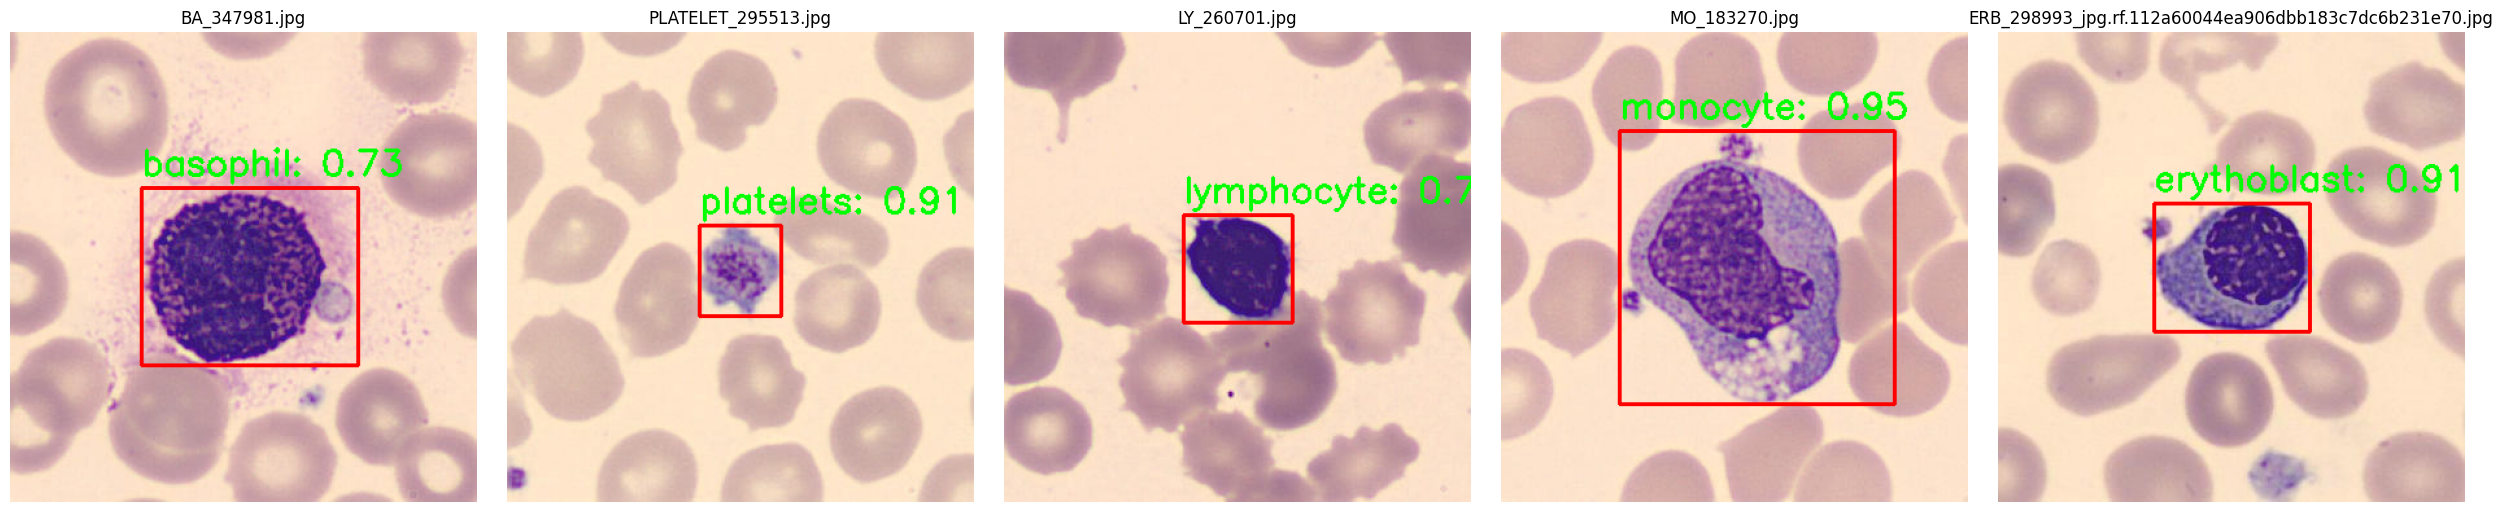

In [26]:
%matplotlib inline
# Load the trained model
model = YOLO("/Users/afnanag/projects/DH307/yolov11/runs/detect/train4/weights/best.pt")

# Path to validation images
val_img_dir = "/Users/afnanag/projects/DH307/yolov11/data/val/images"

# Get all image files in the validation directory
image_files = [f for f in os.listdir(val_img_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

# Randomly select a subset of images (e.g., 5 images)
num_images = min(5, len(image_files))  # Adjust number if fewer images exist
random_imgs = random.sample(image_files, num_images)

# Set up the figure for multiple images
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))

if num_images == 1:
    axes = [axes]  # Ensure axes is iterable if only one image is selected

# Process each image
for ax, img_name in zip(axes, random_imgs):
    img_path = os.path.join(val_img_dir, img_name)

    # Predict
    results = model(img_path)
    result = results[0]  # Access first result

    # Load and convert image for display
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract bounding boxes
    boxes = result.boxes.xyxy.cpu().numpy()
    confidences = result.boxes.conf.cpu().numpy()
    class_indices = result.boxes.cls.cpu().numpy()

    # Draw bounding boxes
    for box, conf, class_idx in zip(boxes, confidences, class_indices):
        x1, y1, x2, y2 = map(int, box)
        label = f"{result.names[int(class_idx)]}: {conf:.2f}"
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image
    ax.imshow(image_rgb)
    ax.axis("off")
    ax.set_title(img_name)

plt.tight_layout()
plt.show()



## Prediction on Combined Image

In [27]:
# Load the trained model
model = YOLO("/Users/afnanag/projects/DH307/yolov11/runs/detect/train4/weights/best.pt")

# Predict on an image.
img_path = "/Users/afnanag/Desktop/img2.png"
results = model(img_path)

# Since results is a list, access the first result (index 0)
result = results[0]

# Visualizing the results (this will display the image with bounding boxes and class labels)
result.show()


image 1/1 /Users/afnanag/Desktop/img2.png: 384x384 2 neutrophils, 29.6ms
Speed: 0.9ms preprocess, 29.6ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 384)


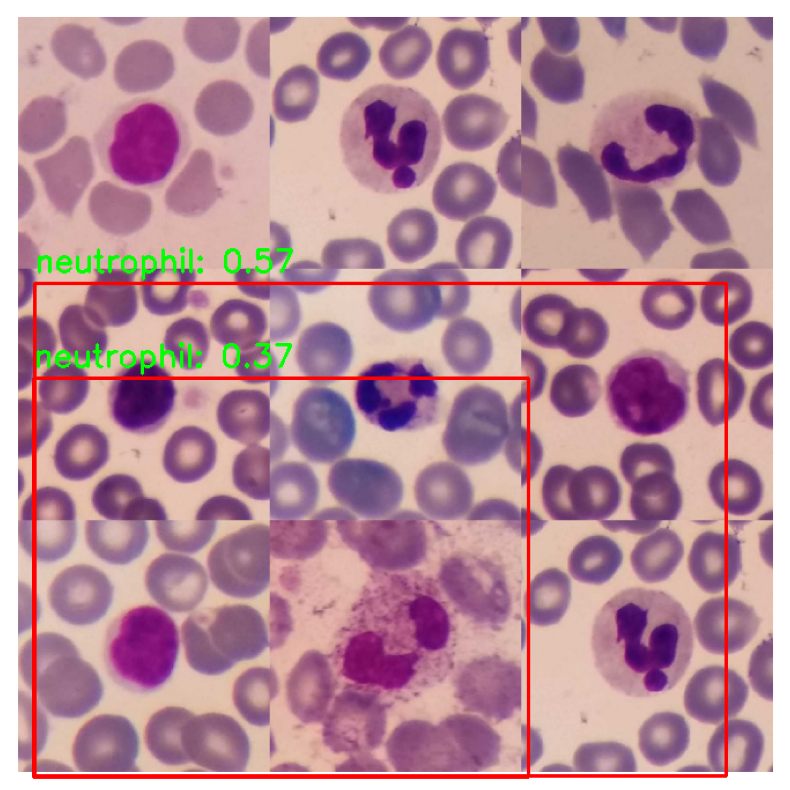

In [28]:
%matplotlib inline
# Extract bounding boxes
boxes = result.boxes.xyxy.cpu().numpy()  # Convert to NumPy
confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
class_indices = result.boxes.cls.cpu().numpy()  # Class indices

# Load the image using OpenCV
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw bounding boxes
for box, conf, class_idx in zip(boxes, confidences, class_indices):
    x1, y1, x2, y2 = map(int, box)
    label = f"{result.names[int(class_idx)]}: {conf:.2f}"
    cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
    cv2.putText(image_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


In [31]:
# Prediction with lower confidence
results = model(img_path, conf=0.1)  # Lower confidence threshold

result = results[0]

# Visualizing the results
result.show()



image 1/1 /Users/afnanag/Desktop/img2.png: 384x384 4 neutrophils, 36.8ms
Speed: 1.4ms preprocess, 36.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 384)
